# Vehicle Detection

Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

A PDF version of this report would be made available within this repository

## Histogram of Oriented Gradients (HOG)

**Explain how (and identify where in your code) you extracted HOG features from the training images.**

The code for this step is contained in the first code cell of the IPython notebook.

I started by reading in all the vehicle and non-vehicle images. 
The vehicle images are generously provided by GTI vehicle image database and the KITTI vision benchmark suite.

In order to get the images in, we would run the following commands in linux/mac environment

```
wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip
unzip vehicles.zip
unzip non-vehicles.zip
```

Running the bash commands above would yield the vehicles and non-vehicles folders which would contain the images that would be used to train to identify vehicles in an image.

Here is an example of one of each of the vehicle and non-vehicle classes:

(64, 64, 3)


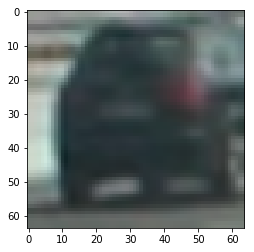

In [3]:
# Example Vehicle image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('./vehicles/GTI_Left/image0019.png')
print(image.shape)
plt.imshow(image)

(64, 64, 3)


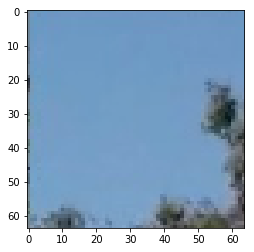

In [4]:
# Example Non-Vehicle image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('./non-vehicles/Extras/extra1.png')
print(image.shape)
plt.imshow(image)

**Observation of Example Images**

Images are generally of 64 by 64 color images.

**Explain how you settled on your final choice of HOG parameters.**

Before selecting how the HOG parameters were decided on, we would first do some quick data exploration to determine what would be the best color channel to try to use HOG on. (HOG works on a single color channel). After which, we do some quick data exploration on the effects of the HOG parameters on the output of the HOG variable.

In [9]:
import cv2

# Defining color filters

def rgb_convert(image, filter=None):
    '''
    Provide RGB image for processing. Allows one to select color filter and even color thresholding
    '''
    # Apply color filter
    if filter == 'r':
        image = image[:,:,0]
    if filter == 'g':
        image = image[:,:,1]
    if filter == 'b':
        image = image[:,:,2]
    return image

def hls_convert(image, filter=None):
    '''
    Provide RGB image for processing. Image will be converted to hls image. Allow one to select hls filter and hls
    thresholding
    '''
    # Convert to hls image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Apply color filter
    if filter == 'h':
        image = image[:,:,0]
    if filter == 'l':
        image = image[:,:,1]
    if filter == 's':
        image = image[:,:,2]
    return image

def gray_convert(image):
    '''
    Wrapper to easily reference to convert image to gray image
    '''
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

In [18]:
# Color images will be tested to see clarity of vehicle when compared to background
# We will be using one of the images from the dataset to see what the algorithm need
image_for_analysis = mpimg.imread('./vehicles/GTI_Left/image0009.png')

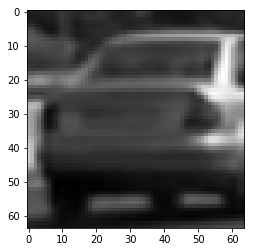

In [19]:
# Gray image
gray_image = gray_convert(image_for_analysis)
plt.imshow(gray_image, cmap='gray')

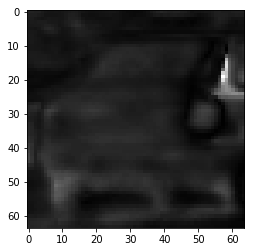

In [20]:
# Saturated image based on HLS color scheme
saturated_image = hls_convert(image_for_analysis, 's')
plt.imshow(saturated_image, cmap='gray')

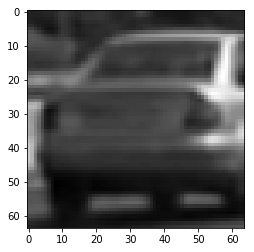

In [21]:
# Lightness image based on HLS color scheme
lightness_image = hls_convert(image_for_analysis, 'l')
plt.imshow(lightness_image, cmap='gray')

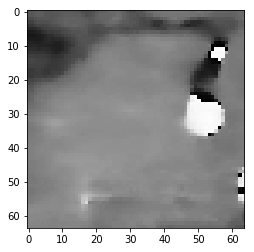

In [22]:
# Hue image based on HLS color scheme
hue_image = hls_convert(image_for_analysis, 'h')
plt.imshow(hue_image, cmap='gray')

**Observation**

We would not use RGB colors. Reason for this is that the car comes in various colors; e.g. Red, Blue, Green cars which means if we try to filter only for such channel, we could possibly lose out on all those mentioned colors. 

Based on the above, we would have a choice to choose either grayscale images on images based on lightness via HLS color scale. For simplicity purposes, we would just use grayscale this time.

In [44]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    '''
    Get Hog Features from image.
    :param img: Image has to be a single color channel image
    :param orient: Represents the number of orientation bins that the gradient information will be split up into in the histogram
    :param pix_per_cell: Specifies the cell size over which each gradient histogram is computed. 
    :param cell_per_block: Specifies the local area over which the histogram counts in a given cell will be normalized
    :param vis: A boolean that takes care whether to create outputs that can be used for vizualization purposes
    :param feature_vec: A boolean that takes where to convert an 'image-like' object can be converted to a single vector for use of training
    '''
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False, visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

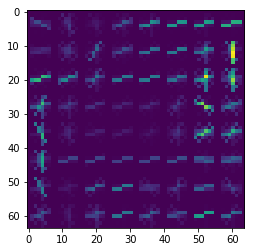

In [45]:
# Test out orient
orient_test_features, orient_test_hog_image = get_hog_features(gray_image, 9, 8, 2, vis=True)
plt.imshow(orient_test_hog_image)

**Observation**

We would proceed with the above settings of 9 for orient with 8 by 8 pixels per cell. Reason for supporting this is based of earlier research as mentioned within this wikipedia article.

https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients

**Defining required feature extraction functions**

HOG would probably be one of the main important functions to use to identify whether an image contains a car or not - It somewhat get shape informaiton into the model. However, that is not the only way to tell whether the image contains a car or not. We can use color histograms and/or color spaces as well.

In [ ]:
# Define a function to compute color histogram features  
def color_hist(img, cspace='RGB', nbins=32, bins_range=(0, 256)):
    # Decide which color space to split on
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(img)      
    # Generate histogram features
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [ ]:
# Define the feature extraction function to be used to classify the images
def extract_features(imgs):
     # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read the image file
        image = mpimg.imread(file)

        # Define the variables needed for using HOG
        gray_image = gray_convert(image)
        hog_features = get_hog_features(gray_image, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)

        # Define the color histograms that are to be used
        # color_hist_features = color_hist(image, cspace='HLS', nbins=32)
        
        features.append(hog_features)

Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using the above HOG features across the image dataset. 

## Sliding Window Search

**Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?**

DESCRIPTION TO BE ADDED

**Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?**

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result. Here are some example images:

## Video Implementation

**Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)**

ADD VIDEO LINK HERE

**Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.**

I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I then used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. I constructed bounding boxes to cover the area of each blob detected.

Here's an example result showing the heatmap from a series of frames of video, the result of scipy.ndimage.measurements.label() and the bounding boxes then overlaid on the last frame of video: